In [ ]:
#installing SHAP
!pip install utils shap

  Preparing metadata (setup.py) ... done
  Created wheel for utils: filename=utils-1.0.2-py2.py3-none-any.whl size=13906 sha256=a5764011b4ae53095f2b765c1088c717fb1cddf799e6e5cce11b9a64fe25fdc7
  Stored in directory: /root/.cache/pip/wheels/15/0c/b3/674aea8c5d91c642c817d4d630bd58faa316724b136844094d
Successfully built utils


In [ ]:
#importing necessary packages
import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
import shap

import sys
sys.path.append('../')
import utils

from sklearn.preprocessing import RobustScaler
rob_scaler = RobustScaler()

In [ ]:
#loading the dataset
credit_score = pd.read_csv("https://raw.githubusercontent.com/fenago/datasets/refs/heads/main/credit_score.csv")

credit_score.columns

Index(['CUST_ID', 'INCOME', 'SAVINGS', 'DEBT', 'R_SAVINGS_INCOME',
       'R_DEBT_INCOME', 'R_DEBT_SAVINGS', 'T_CLOTHING_12', 'T_CLOTHING_6',
       'R_CLOTHING', 'R_CLOTHING_INCOME', 'R_CLOTHING_SAVINGS',
       'R_CLOTHING_DEBT', 'T_EDUCATION_12', 'T_EDUCATION_6', 'R_EDUCATION',
       'R_EDUCATION_INCOME', 'R_EDUCATION_SAVINGS', 'R_EDUCATION_DEBT',
       'T_ENTERTAINMENT_12', 'T_ENTERTAINMENT_6', 'R_ENTERTAINMENT',
       'R_ENTERTAINMENT_INCOME', 'R_ENTERTAINMENT_SAVINGS',
       'R_ENTERTAINMENT_DEBT', 'T_FINES_12', 'T_FINES_6', 'R_FINES',
       'R_FINES_INCOME', 'R_FINES_SAVINGS', 'R_FINES_DEBT', 'T_GAMBLING_12',
       'T_GAMBLING_6', 'R_GAMBLING', 'R_GAMBLING_INCOME', 'R_GAMBLING_SAVINGS',
       'R_GAMBLING_DEBT', 'T_GROCERIES_12', 'T_GROCERIES_6', 'R_GROCERIES',
       'R_GROCERIES_INCOME', 'R_GROCERIES_SAVINGS', 'R_GROCERIES_DEBT',
       'T_HEALTH_12', 'T_HEALTH_6', 'R_HEALTH', 'R_HEALTH_INCOME',
       'R_HEALTH_SAVINGS', 'R_HEALTH_DEBT', 'T_HOUSING_12', 'T_HOUSING_6',
 

In [ ]:
credit_score.head()

,CUST_ID,INCOME,SAVINGS,DEBT,R_SAVINGS_INCOME,R_DEBT_INCOME,R_DEBT_SAVINGS,T_CLOTHING_12,T_CLOTHING_6,R_CLOTHING,...,R_EXPENDITURE_SAVINGS,R_EXPENDITURE_DEBT,CAT_GAMBLING,CAT_DEBT,CAT_CREDIT_CARD,CAT_MORTGAGE,CAT_SAVINGS_ACCOUNT,CAT_DEPENDENTS,CREDIT_SCORE,DEFAULT
0,C02COQEVYU,33269,0,532304,0.0000,16.0000,1.2000,1889,945,0.5003,...,0.0000,0.0625,High,1,0,0,0,0,444,1
1,C02OZKC0ZF,77158,91187,315648,1.1818,4.0909,3.4615,5818,111,0.0191,...,0.7692,0.2222,No,1,0,0,1,0,625,0
2,C03FHP2D0A,30917,21642,534864,0.7000,17.3000,24.7142,1157,860,0.7433,...,1.4286,0.0578,High,1,0,0,1,0,469,1
3,C03PVPPHOY,80657,64526,629125,0.8000,7.8000,9.7499,6857,3686,0.5376,...,1.2500,0.1282,High,1,0,0,1,0,559,0
4,C04J69MUX0,149971,1172498,2399531,7.8182,16.0000,2.0465,1978,322,0.1628,...,0.1163,0.0568,High,1,1,1,1,1,473,0


#**Linear Regression Model**

In [ ]:
#adding the squared term
credit_score['R_EXPENDITURE_SQR'] = credit_score['R_EXPENDITURE']**2

#selecting features for X
X = credit_score[['R_SAVINGS_INCOME','R_DEBT_INCOME','R_HOUSING','R_EXPENDITURE_SQR','R_ENTERTAINMENT','CAT_GAMBLING']].copy()

#feature engineering
X['GAMBLING_LOW'] = X['CAT_GAMBLING'].apply(lambda x: 1 if x == 'Low' else 0)
X['GAMBLING_HIGH']  = X['CAT_GAMBLING'].apply(lambda x: 1 if x == 'High' else 0)
X.drop(columns=['CAT_GAMBLING'], inplace=True)

#creating the target variable
y = credit_score['CREDIT_SCORE']

X.head()

,R_SAVINGS_INCOME,R_DEBT_INCOME,R_HOUSING,R_EXPENDITURE_SQR,R_ENTERTAINMENT,GAMBLING_LOW,GAMBLING_HIGH
0,0.0000,16.0000,0.5060,0.336052,0.5065,0,1
1,1.1818,4.0909,0.5061,0.128164,0.5042,0,0
2,0.7000,17.3000,0.5056,0.324672,0.6178,0,1
3,0.8000,7.8000,0.5061,0.248502,0.5094,0,1
4,7.8182,16.0000,0.5061,0.211968,0.5150,0,1


In [ ]:
#here we are creating a linear regression model to interpret the summary of the model

#adding a constant/reference to the dependent variables
X = sm.add_constant(X)

#fitting the model
model = sm.OLS(y, X).fit()

#printing out the summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           CREDIT_SCORE   R-squared:                       0.803
Model:                            OLS   Adj. R-squared:                  0.801
Method:                 Least Squares   F-statistic:                     576.2
Date:                Tue, 18 Feb 2025   Prob (F-statistic):               0.00
Time:                        21:45:54   Log-Likelihood:                -4756.8
No. Observations:                1000   AIC:                             9530.
Df Residuals:                     992   BIC:                             9569.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              -603.8832   3941.78

#Notes about the summary:

**R Sq:** Our R Squared is is 0.803 which is not too bad given that it is pretty close to 1.

**Adjusted R Sq:** Our Adjusted R Squared is 0.801 which is also good. This might be the better metric to look at in comparison to R Squared as we have multiple predictors.

**F Statistic:** Our F Statistic is 576.2 which is showing us that the overall model is very strong. However, the F Statistic still needs to be cross referneced with the p value of a column to determine if it is a good fit or not.

**P Values:** We have high p values for R_Housing (0.733) and R_Savings_Income (0.450). These are features that can possibly be removed.

**Prob (F-statistic):** 0.0, Which is good, considering this represents the p value of the entire model.

**Coefficients:** Evaluated in the formula/code below

**Standard Error:** We have a high standard error for R_Housing (7788.227) that is greater than its coefficient (2658.9305), which indicates a non-reliable estimate.

**T Statistic:** R_Housing and R_Savings_Income have relatively low T Statistics.

**Condition No:** The condition number is large, 8.67e+04. This might indicate that there are strong multicollinearity (when two variables are closely related) or other numerical problems.

**Skew:** The Skew is 1.126, which means that in Gaussian/Normal Distribution, this model is pretty much perfectly symmetrical, no tails to the left of the bell curve or to the right of the bell curve. Had it been a postivie skew, more than 1, it would result in a slight right tail, and a negative skew, more than -1, it would result in a slight left tail.

**Kurtosis:** Our Kurtosis is 7.781, which means we have some extreme outliers.

In [ ]:
#writing out the equations for the model
print("y = {:.2f} + {:.5f}*R_SAVINGS_INCOME + {:.2f}*R_DEBT_INCOME  + {:.2f}*R_HOUSING + {:.2f}*R_EXPENDITURE_SQR + {:.2f}*R_ENTERTAINMENT + {:.2f}*GAMBLING_LOW + {:.2f}*GAMBLING_HIGH".format(model.params[0], model.params[1], model.params[2], model.params[3], model.params[4], model.params[5], model.params[6], model.params[7]))

#writing the equation using values from the first row in the dataset
X_0 = X.iloc[0,:]
print("y = {:.2f} + {:.5f}*{} + {:.2f}*{} + {:.2f}*{} + {:.2f}*{:.5f} + {:.2f}*{} + {:.2f}*{} + {:.2f}*{}".format(model.params[0], model.params[1], X_0['R_SAVINGS_INCOME'], model.params[2], X_0['R_DEBT_INCOME'], model.params[3], X_0['R_HOUSING'], model.params[4], X_0['R_EXPENDITURE_SQR'], model.params[5], X_0['R_ENTERTAINMENT'], model.params[6], X_0['GAMBLING_LOW'], model.params[7], X_0['GAMBLING_HIGH']))

#constant with predicted values from the model summary and the actual values from the dataset from the first row
print(-603.88 + -0.1886*0.0  + -9.2688*16.0 + 2658.9305*0.5060 + -151.9770*0.336052 + -93.3918*0.5065 + -13.4565*0.0 + -17.389*1)

y = -603.88 + -0.18859*R_SAVINGS_INCOME + -9.27*R_DEBT_INCOME  + 2658.93*R_HOUSING + -151.98*R_EXPENDITURE_SQR + -93.39*R_ENTERTAINMENT + -13.46*GAMBLING_LOW + -17.39*GAMBLING_HIGH
y = -603.88 + -0.18859*0.0 + -9.27*16.0 + 2658.93*0.506 + -151.98*0.33605 + -93.39*0.5065 + -13.46*0.0 + -17.39*1.0
477.4739114959999


<ipython-input-7-5e54c376f47a>:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("y = {:.2f} + {:.5f}*R_SAVINGS_INCOME + {:.2f}*R_DEBT_INCOME  + {:.2f}*R_HOUSING + {:.2f}*R_EXPENDITURE_SQR + {:.2f}*R_ENTERTAINMENT + {:.2f}*GAMBLING_LOW + {:.2f}*GAMBLING_HIGH".format(model.params[0], model.params[1], model.params[2], model.params[3], model.params[4], model.params[5], model.params[6], model.params[7]))
<ipython-input-7-5e54c376f47a>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("y = {:.2f} + {:.5f}*{} + {:.2f}*{} + {:.2f}*{} + {:.2f}*{:.5f} + {:.2f}*{} + {:.2f}*{} + {:.2f}*{}".format(model.params[0], mode

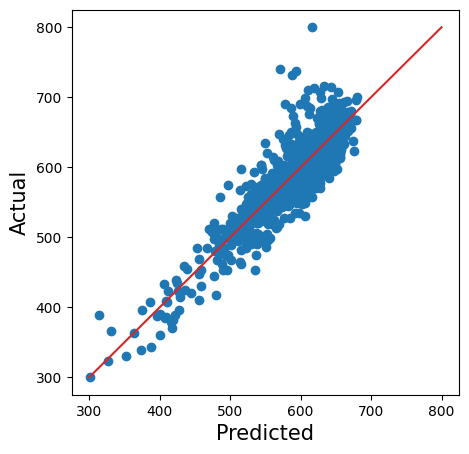

In [ ]:
#getting the model predictions for visualization
y_pred = model.predict(X)

#plotting predicted vs actual
fig, ax = plt.subplots(figsize=(5, 5))
plt.scatter(y_pred,y)

ax.plot([y.min(), y.max()], [y.min(), y.max()], color='tab:red')

plt.xlabel('Predicted',size=15)
plt.ylabel('Actual', size=15)

#save figure
fig.savefig("LM4_residuals.png", bbox_inches='tight')

Here we can see that the model is not too far off in making predictions

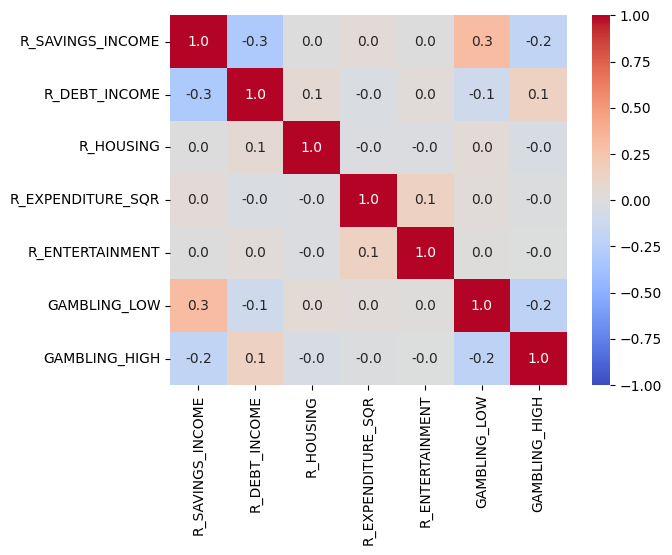

In [ ]:
#creating a correlation matrix
corr_matrix = X.drop('const',axis=1).corr()
sns.heatmap(corr_matrix, cmap="coolwarm", fmt=".1f", vmin=-1, vmax=1,annot=True)

#save figure
fig.savefig("LM4_corr_heatmap.png", bbox_inches='tight')

##Noticeable Correlations

**R_SAVINGS_INCOME and R_DEBT_INCOME:** have a correlation of -0.3. This indicates a moderate negative relationship between these two variables. The negative sign indicates that as one variable increases, the other variable tends to decrease. The value of -0.3 suggests a moderate relationship. It's not very strong, but there is a noticeable inverse relationship. As the savings relative to income increases, the debt relative to income tends to decrease. Conversely, as the debt relative to income increases, the savings relative to income tends to decrease.

**R_SAVINGS_INCOME and GAMBLING_HIGH:** have a correlation of -0.2

**R_SAVINGS_INCOME and GAMBLING_LOW:** have a correlation of 0.3

**R_DEBT_INCOME and GAMBLING_HIGH:** have a correlation of 0.1

**R_DEBT_INCOME and GAMBLING_LOW:** have a correlation of -0.1

**R_DEBT_INCOME and R_HOUSING:** have a correlation of 0.1

**R_EXPENDITURE_SQR and R_ENTERTAINMENT:** have a correlation of 0.1

**GAMBLING_LOW and GAMBLING_HIGH:** have a correlation of -0.2

Higher correlation coefficients between features might be an indication of multicollinearity and one of the columns might need to be removed. If they both seem to be important features to the model, intuitively speaking (if you feel debt and income are important features, for example), then maybe transforming one of these features by standardizing it, for example, might simplify the model.

#**T-Statistic**

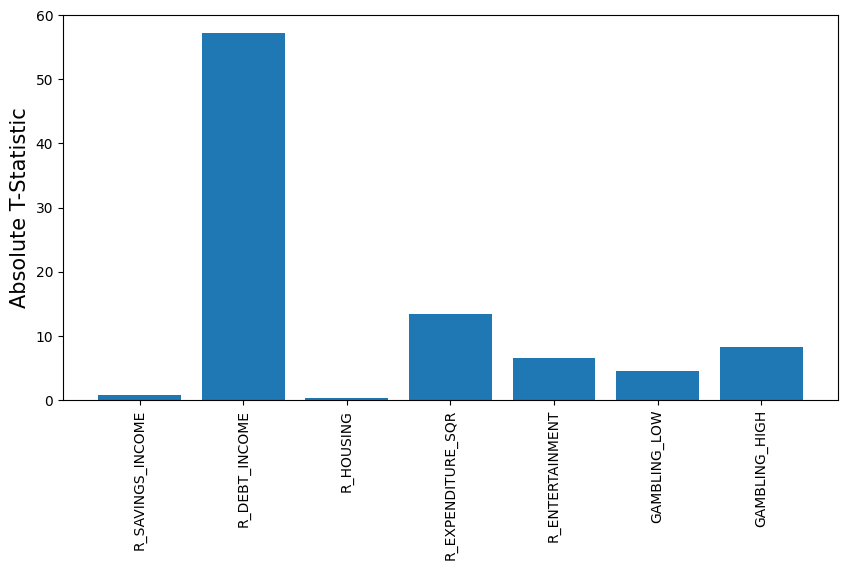

In [ ]:
#getting the absolute values of the t-statistics from the model
t_statistic = model.tvalues[1:] # exclude the constant
abs_t_statistic = abs(t_statistic)

#creating a bar plot for feature importance
plt.figure(figsize=(10, 5))
plt.bar(X.columns[1:], abs_t_statistic)

plt.ylabel('Absolute T-Statistic',size=15)
plt.xticks(rotation=90)

fig.savefig("LM4_abs_t_statistic.png", bbox_inches='tight')

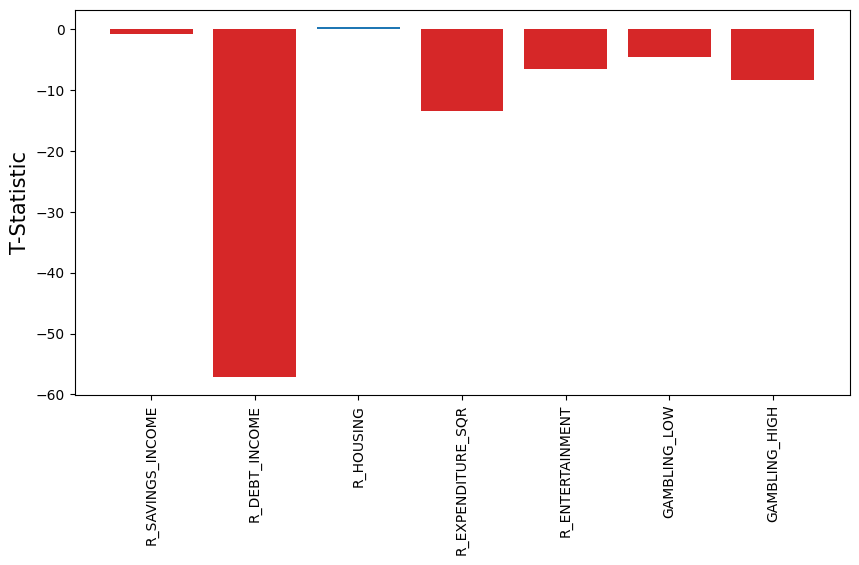

In [ ]:
#color coordinating positive (blue) and negative (red) impacts of the t-statistics
colors = ['tab:red' if t < 0 else 'tab:blue' for t in t_statistic]

plt.figure(figsize=(10, 5))
plt.bar(X.columns[1:], t_statistic, color=colors)

plt.ylabel('T-Statistic', size=15)
plt.xticks(rotation=90)

fig.savefig("LM4_t_statistic.png", bbox_inches='tight')

##T Statistic Summary
A higher absolute t-statistic value indicates that the feature has a stronger effect on the target variable. Features with t-statistics close to zero have less impact and can often be dropped without losing predictive power.

The t-statistic is used to test the null hypothesis that a particular coefficient is equal to zero (meaning the feature has no effect). A high absolute t-statistic (typically > 2) suggests rejecting the null hypothesis, implying that the feature significantly affects the target variable. Features with large absolute t-statistics are crucial to the model’s predictions.

We can see from the visual that R_DEBT_INCOME has the highest impact on the target variable while R_HOUSING and R_SAVINGS_INCOME have very little impact.

#**Weight Plot**

Text(0.5, 0, 'Coefficient (Weight)')

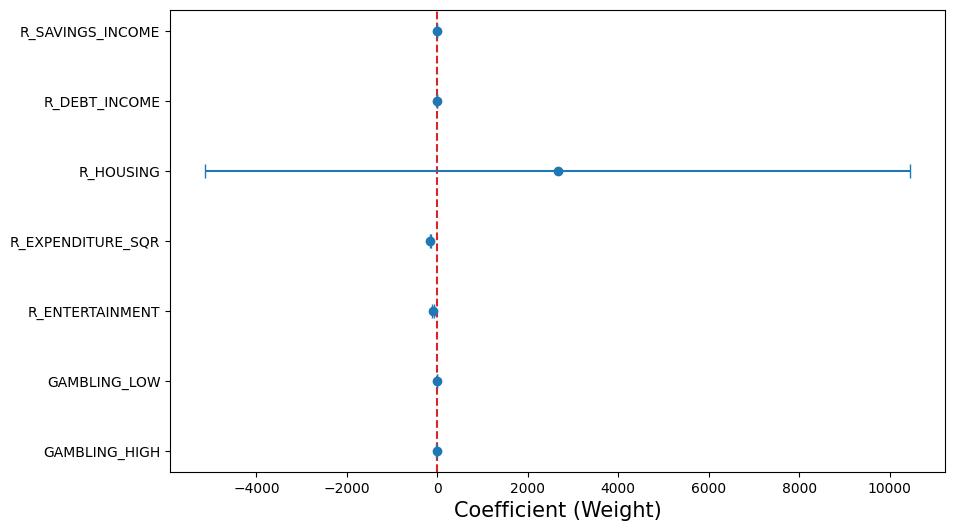

In [ ]:
#getting coefficients and standard errors
coefficients = model.params[1:][::-1]
se = model.bse[1:][::-1]
features = X.columns[1:][::-1]

#visualizing the weight plot
plt.figure(figsize=(10, 6))

#plotting the vertical dotted line at x=0
plt.axvline(x=0, color='tab:red', linestyle='--')

#plotting the coefficients and error bars
plt.errorbar(coefficients,
             features,
             xerr=se,
             fmt='o',
             capsize=5)

plt.xlabel('Coefficient (Weight)', size=15)

##Weight Plot

Visualizes the coefficients of a linear model, helping to understand the direction (positive or negative) and magnitude of each feature’s effect on the target variable. Weights are the coefficients obtained from the linear regression model. They represent the degree of change in the target variable (y) for a one-unit change in the corresponding feature, holding other features constant. Positive Weights: Indicate that as the feature value increases, the target value also increases. Negative Weights: Indicate that as the feature value increases, the target value decreases. The larger the absolute value of the weight, the more influential the feature is on the target variable. The Weight Plot will visually highlight the most impactful features by the length of the bars. Features with larger bars (either positive or negative) are the ones driving the model’s predictions the most.


According to this weight plot, R_HOUSING is the most impactful feature.

Lets scale the data and see what happens.

In [ ]:
#we are going to scale the the data and try visualizing the weight plot again
scaler = StandardScaler()

#scaling the features
X_scaled = scaler.fit_transform(X.drop(columns='const'))
X_scaled = pd.DataFrame(X_scaled, columns=X.columns[1:])
X_scaled = sm.add_constant(X_scaled)

#fitting a linear regression model with scaled features
model_scaled = sm.OLS(y, X_scaled).fit()

#output
print(model_scaled.summary())

                            OLS Regression Results                            
Dep. Variable:           CREDIT_SCORE   R-squared:                       0.803
Model:                            OLS   Adj. R-squared:                  0.801
Method:                 Least Squares   F-statistic:                     576.2
Date:                Tue, 18 Feb 2025   Prob (F-statistic):               0.00
Time:                        22:04:06   Log-Likelihood:                -4756.8
No. Observations:                1000   AIC:                             9530.
Df Residuals:                     992   BIC:                             9569.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               586.7120      0.89

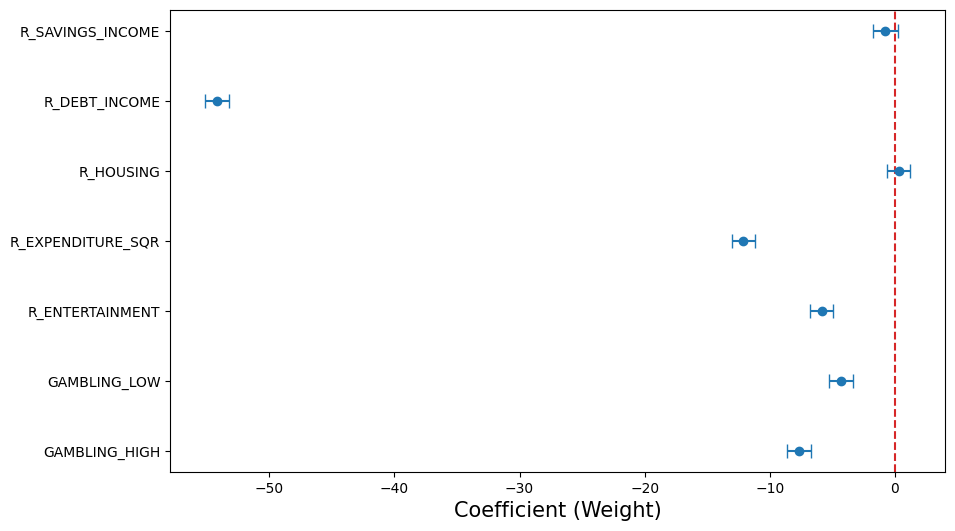

In [ ]:
#creating the weight plot with scaled features
coefficients = model_scaled.params[1:][::-1]
se = model_scaled.bse[1:][::-1]
features = X_scaled.columns[1:][::-1]

plt.figure(figsize=(10, 6))
plt.axvline(x=0, color='tab:red', linestyle='--')
plt.errorbar(coefficients,
             features,
             xerr=se,
             fmt='o',
             capsize=5)
plt.xlabel('Coefficient (Weight)', size=15)

fig.savefig("LM4_weight_plot_scaled.png", bbox_inches='tight')

##Weight Plot Summary
Now that the data is scaled, most of the features seem to have a more equal relevancy according to the weight plot. Features that have little to no 'weight' can be dropped or re-engineered if applicable.

#**Effect Plot**

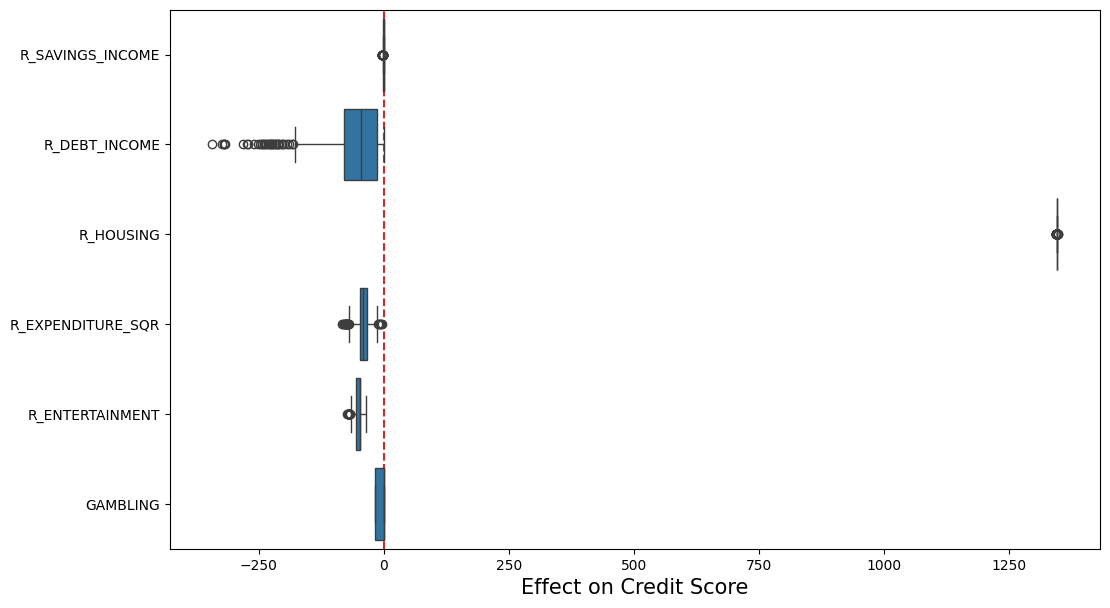

In [ ]:
#code to generate an effect plot as a reference
#calculating the feature effects
feature_effects = X * model.params

#combining feature effects for related features (e.g., GAMBLING_LOW and GAMBLING_HIGH can just be 'GAMBLING', it doesnt need to be 2 different features)
feature_effects['GAMBLING'] = feature_effects['GAMBLING_LOW']+feature_effects['GAMBLING_HIGH']
feature_effects.drop(['const','GAMBLING_LOW','GAMBLING_HIGH'],axis=1,inplace=True)

#creating effect plots using boxplots
plt.figure(figsize=(12, 7))
plt.axvline(x=0, color='tab:red', linestyle='--')
sns.boxplot(data=feature_effects, orient="h", color="tab:Blue")
plt.xlabel("Effect on Credit Score", size=15)

fig.savefig("LM4_effect_plot.png", bbox_inches='tight')

##Effect Plot

Shows the relationship between individual feature values and the corresponding target variable. Unlike the Weight Plot, which shows global feature importance, the Effect Plot provides insights into local feature contributions. Visualizes how a change in a feature’s value impacts the target variable, showing if the relationship is linear, monotonic, or more complex. It plots the feature values on the x-axis and the target values on the y-axis. Positive Effect: As the feature value increases, the target value increases. Negative Effect: As the feature value increases, the target value decreases. Effect plots can reveal non-linear relationships, such as quadratic effects where increasing a feature initially has a positive effect but then becomes negative as the feature value continues to rise.

Effect plots are critical for visualizing how changes in feature values impact the predictions, helping us understand both linear and non-linear effects.

They can also reveal whether transformations (e.g., logarithmic or polynomial) are necessary to better capture relationships.

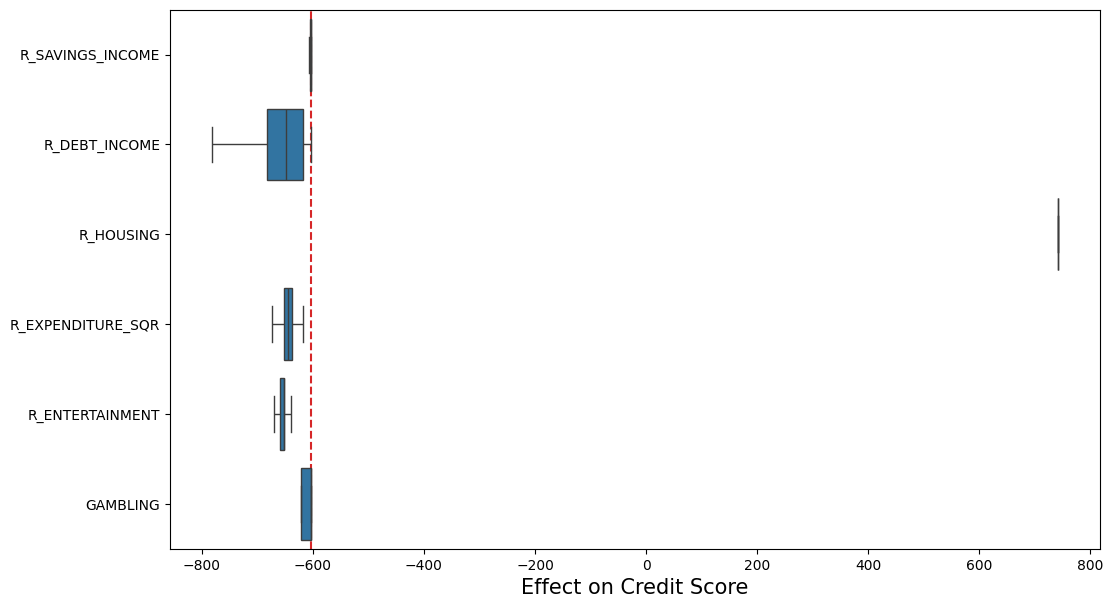

In [ ]:
#here we are actually creating an effect plot based on our data
#calculating the feature effects
feature_effects = X * model.params
const = feature_effects['const'][0]

#combining feature effects for related features
feature_effects['GAMBLING'] = feature_effects['GAMBLING_LOW']+feature_effects['GAMBLING_HIGH']
feature_effects.drop(['const','GAMBLING_LOW','GAMBLING_HIGH'],axis=1,inplace=True)

#adding the constant to the feature effects
feature_effects = feature_effects + const

#creating effect plots using boxplots
plt.figure(figsize=(12, 7))
plt.axvline(x=const, color='tab:red', linestyle='--')
sns.boxplot(data=feature_effects, orient="h", color="tab:Blue", showfliers=False)
plt.xlabel("Effect on Credit Score", size=15)

fig.savefig("LM4_adjusted_effect_plot.png", bbox_inches='tight')

##Effect Plot Summary
According to the effect plot, R_DEBT_INCOME seems to have the biggest effect on the credit score.

#**Mean Effect Plot**

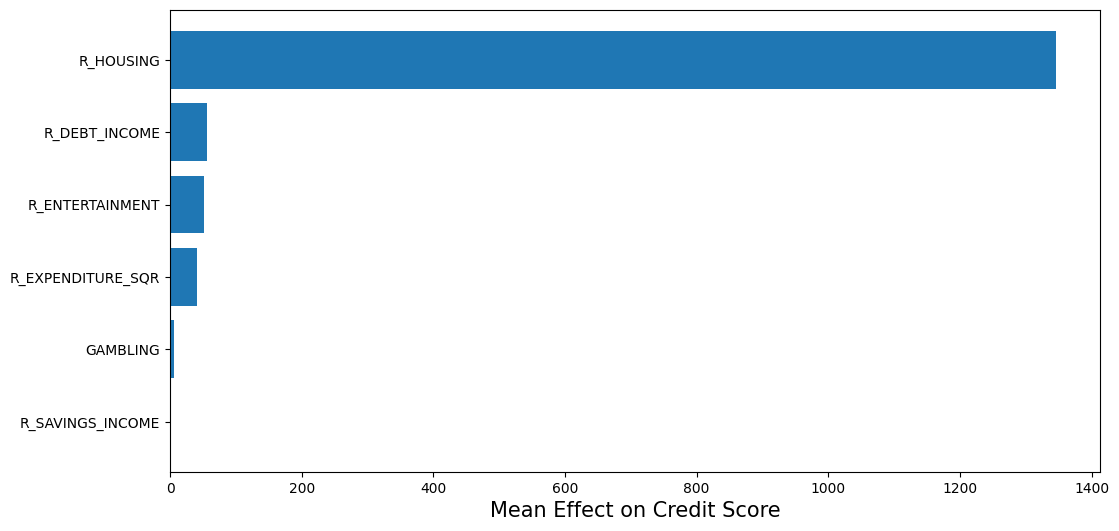

In [ ]:
#calculating the feature effects
feature_effects = X * model.params

#combining feature effects for related features
feature_effects['GAMBLING'] = feature_effects['GAMBLING_LOW']+feature_effects['GAMBLING_HIGH']
feature_effects.drop(['const','GAMBLING_LOW','GAMBLING_HIGH'],axis=1,inplace=True)

#calculating the absolute values of the feature effects
feature_effects = abs(feature_effects)
mean_effects = feature_effects.mean(axis=0)

#sorting by mean effect
mean_effects.sort_values(inplace=True)

#creating a bar plot for feature importance
plt.figure(figsize=(12, 6))
plt.barh(mean_effects.index, mean_effects)
plt.xlabel('Mean Effect on Credit Score', size=15)

fig.savefig("LM4_mean_effect_plot.png", bbox_inches='tight')

##Mean Effect Plot Summary

Takes into account all individual predictions across the dataset to provide an average effect for each feature. This gives a clearer picture of the overall contribution of a feature to the model’s predictions. This plot displays the average effect of each feature on the target variable, combining the insights from all individual predictions into a single view. It provides a more holistic understanding of how a feature behaves on average. Helps identify the overall impact of each feature on the target variable. Simplifies the interpretation by focusing on average behavior rather than individual effects. Positive mean effects indicate that, on average, increasing the feature value leads to an increase in the target variable. Negative mean effects indicate a decrease in the target variable as the feature value increases. The Mean Effect Plot provides a summary view, where each bar represents the average impact of the feature across all predictions.

R_HOUSING has the biggest mean effect and R_SAVINGS_INCOME has the least mean effect.

#**Effect Plot Trend**

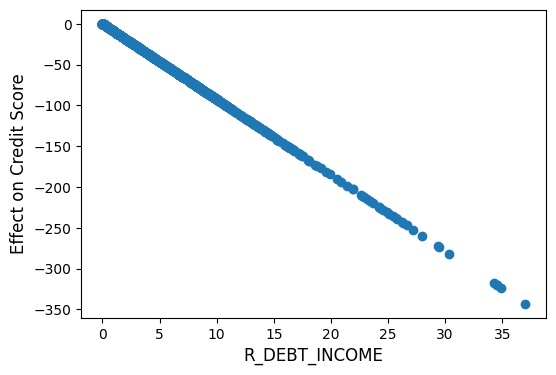

In [ ]:
#calculating the feature effects
feature_effects = X * model.params

#plotting the effect of R_DEBT_INCOME
plt.figure(figsize=(6, 4))
plt.scatter(X['R_DEBT_INCOME'], feature_effects['R_DEBT_INCOME'])

plt.xlabel('R_DEBT_INCOME', size=12)
plt.ylabel('Effect on Credit Score', size=12)

fig.savefig("LM4_trend_effect_plot.png", bbox_inches='tight')

##Effect Trend Plot Summary

Helps us visualize how the prediction changes as a feature value varies across its range, while keeping all other features constant. This plot is useful for understanding not just the overall relationship but also identifying any patterns, thresholds, or changes in trend. This plot illustrates how changes in a specific feature’s value influence the target variable’s prediction. It captures the marginal effect of a feature across its entire range, revealing patterns such as linearity, thresholds, or saturation points. Linear Trend: A straight line indicates a constant relationship between the feature and the target. Non-Linear Trend: Curves or bends indicate a non-linear effect, such as diminishing returns or exponential growth. Threshold Points: Sharp changes or plateaus may suggest a threshold where the effect of the feature changes dramatically. The slope and shape of the line in the effect trend plot tell us whether a feature has a linear, exponential, or diminishing effect on the target variable. An effect trend plot showing a flat line suggests that the feature has little to no effect on the target variable, regardless of its value.

R_DEBT_INCOME shows a straight linear pattern, indiciating a constant relationship between R_DEBT_INCOME and CREDIT_SCORE.

#**Individual Effect Plot**

444


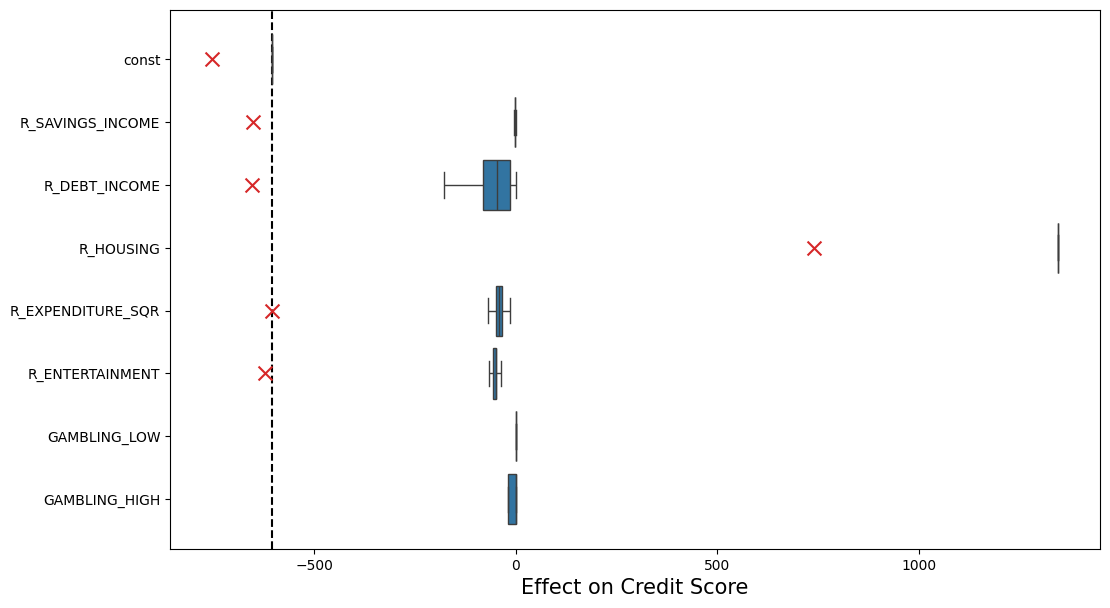

In [ ]:
#creating effect plots using boxplots
plt.figure(figsize=(12, 7))
plt.axvline(x=const, color='black', linestyle='--')
sns.boxplot(data=feature_effects, orient="h", color="tab:Blue", showfliers=False)
plt.xlabel("Effect on Credit Score", size=15)

idx = 0  # You can change this to any valid index in your dataset
ind_feature_effect = X.iloc[idx] * model.params[1:]
print(y[idx])

#combining feature effects for related features
ind_feature_effect['GAMBLING'] = ind_feature_effect['GAMBLING_LOW']+ind_feature_effect['GAMBLING_HIGH']
ind_feature_effect.drop(['const','GAMBLING_LOW','GAMBLING_HIGH'],axis=0,inplace=True)

#adding the constant to the feature effects
ind_feature_effect = ind_feature_effect + const

for i, feature in enumerate(ind_feature_effect):
    plt.scatter(feature, i, c='tab:red', marker='x', s=100, zorder=10)

fig.savefig("LM4_individual_effect_plot.png", bbox_inches='tight')

##Individual Effect Plot

Goes beyond average trends to show how a feature affects each individual data point’s prediction. This plot is crucial for understanding how consistent or variable the feature’s influence is across the dataset. This plot displays the contribution of a specific feature to each individual prediction, helping to identify if the feature consistently affects predictions or has a varying influence. It is particularly useful for spotting outliers or data points where the feature behaves unexpectedly. Consistent Effects: If the individual effect plot shows a straight line or a tight cluster of points, it indicates that the feature has a uniform effect across most data points. Variable Effects: A scattered or irregular pattern indicates that the feature affects different data points in different ways, suggesting interactions or nonlinear relationships. Outliers can be identified if a few data points have significantly different contributions from the rest of the dataset.

##Red X Markers and Box and Whiskers

-Red X Markers: Each red 'x' is placed along the x-axis according to the magnitude of the feature's effect on the credit score. A marker to the right of the vertical dashed line (baseline) indicates a positive effect, while a marker to the left indicates a negative effect. The distance of the 'x' from the vertical dashed line shows how strong the effect is. The farther the 'x' is from the line, the greater the impact of that feature. This helps to quickly identify which features have the most significant influence on the credit score for the individual. By examining the red 'x' markers, you can see a detailed view of how each feature contributes to the credit score for the specific individual. This can be particularly useful for understanding personalized predictions and identifying key factors influencing the score.

-Box aned Whiskers: The boxplot provides a summary of the distribution of feature effects across the entire dataset. It shows the median, interquartile range (IQR), and the range of the data (excluding outliers).

Box: Represents the IQR, containing the middle 50% of the data.

Line Inside the Box: Indicates the median effect.

Whiskers: Extend to the smallest and largest values within 1.5 times the IQR from the lower and upper quartiles.

Variation and Spread: The boxplot helps to understand the variability and spread of feature effects across all individuals in the dataset.

According to the Individual Effect Plot, R_HOUSING has a significant positive impact on the credit score while all of the other features seem have a slight negative impact on the credit score in accordance with the constant/intercept (except for GAMBLING_LOW and GAMBLING_HIGH, as they have no markers on this graph).

<ipython-input-26-d6104cdc7be4>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(X['R_DEBT_INCOME'], kde=False, bins=20, color='tab:blue')


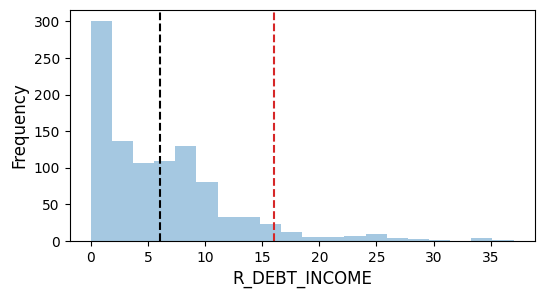

In [ ]:
#plotting distribution of R_DEBT_INCOME
plt.figure(figsize=(6, 3))
sns.distplot(X['R_DEBT_INCOME'], kde=False, bins=20, color='tab:blue')

#adding a vertical line for value of R_DEBT_INCOME for the selected individual
idx = 0
plt.axvline(x=X['R_DEBT_INCOME'][idx], color='tab:red', linestyle='--')

#adding a vertical line for the mean value of R_DEBT_INCOME
plt.axvline(x=X['R_DEBT_INCOME'].mean(), color='black', linestyle='--')

plt.xlabel('R_DEBT_INCOME', size=12)
plt.ylabel('Frequency', size=12)

fig.savefig("LM4_feature_distribution.png", bbox_inches='tight')

The R_DEBT_INCOME histogram above is an example of how you can break each feature down in regard to the Individual Effect Plot.

444
625


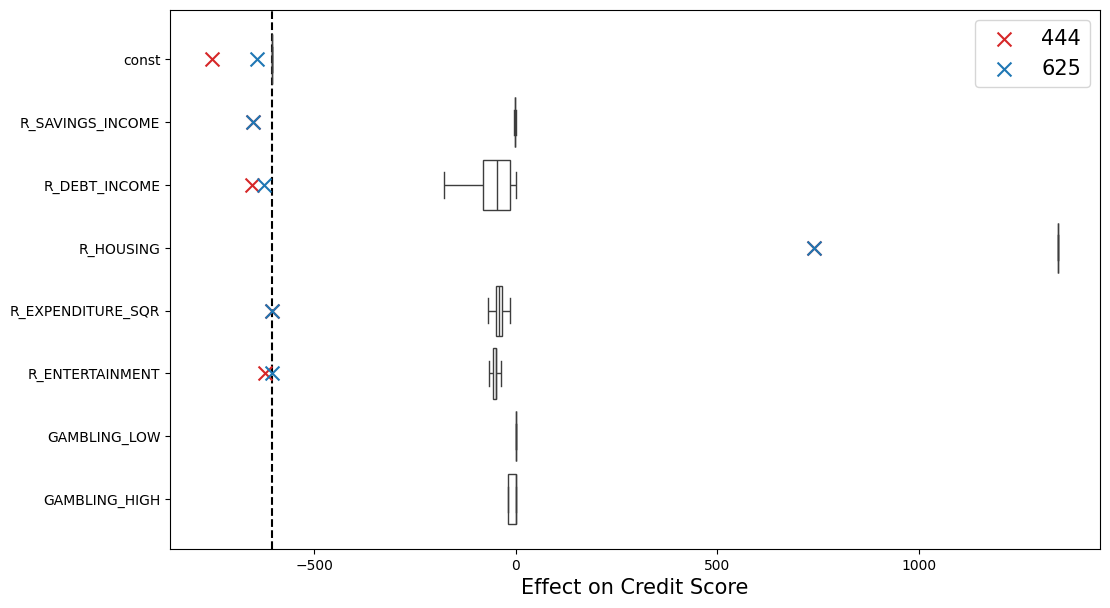

In [ ]:
#creating effect plots using boxplots
plt.figure(figsize=(12, 7))
plt.axvline(x=const, color='black', linestyle='--')
sns.boxplot(data=feature_effects, orient="h", color="white", showfliers=False)
plt.xlabel("Effect on Credit Score", size=15)

colors = ['tab:red','tab:blue']
for idx in [0,1]:
    ind_feature_effect = X.iloc[idx] * model.params[1:]
    print(y[idx])

    #combining feature effects for related features
    ind_feature_effect['GAMBLING'] = ind_feature_effect['GAMBLING_LOW']+ind_feature_effect['GAMBLING_HIGH']
    ind_feature_effect.drop(['const','GAMBLING_LOW','GAMBLING_HIGH'],axis=0,inplace=True)

    #adding the constant to the feature effects
    ind_feature_effect = ind_feature_effect + const

    for i, feature in enumerate(ind_feature_effect):
        if i == 0:
            plt.scatter(feature, i, c=colors[idx], marker='x', s=100, zorder=10,label=y[idx])
        else:
            plt.scatter(feature, i, c=colors[idx], marker='x', s=100, zorder=10)

plt.legend(fontsize=15)

fig.savefig("LM4_individual_effect_plot_2.png", bbox_inches='tight')

##Individual Effect Plot Summary
A more granular visual of the Individual Effect Plot. Here is how the first two rows (two individuals) in the dataset are plotted. The first person has a credit score of 444 and this visual shows you how these features effected that credit score by the markings of the red 'x'. The second person has a credit score of 625 and this visual shows you how these features effected that credit score by the markings of the blue 'x'.

#**PDP (Partial Dependence Plot )**

In [ ]:
#fitting a linear regression model with only debt-to-income ratio for the eventual PDP
model_income = sm.OLS(y, X[['const','R_DEBT_INCOME']]).fit()

#summary output
print(model_income.summary())

                            OLS Regression Results                            
Dep. Variable:           CREDIT_SCORE   R-squared:                       0.736
Model:                            OLS   Adj. R-squared:                  0.736
Method:                 Least Squares   F-statistic:                     2782.
Date:                Tue, 18 Feb 2025   Prob (F-statistic):          7.17e-291
Time:                        22:28:06   Log-Likelihood:                -4902.2
No. Observations:                1000   AIC:                             9808.
Df Residuals:                     998   BIC:                             9818.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const           643.1667      1.486    432.810

Here we can see that the R Squared and Adjustes R Squared look fairly well for the linear regression model for R_Debt_Income as they are both at 0.736. The F Statistic (2782), the Prob F-Statistic (7.17e-291), Skew (0.455), Condition No (12.2), T score, P Value, etc all look good as well. However, the Kurtosis (5.092) is indicating that there might be some outliers.

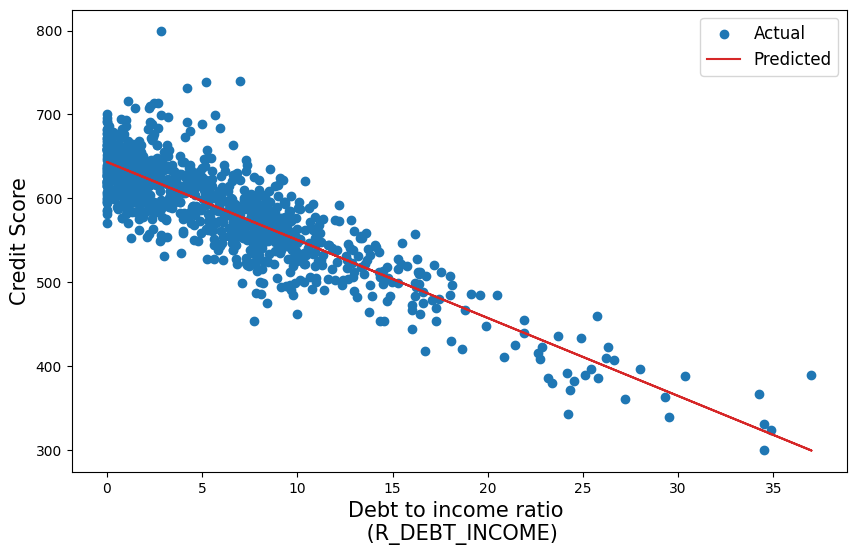

In [ ]:
#plotting credit score vs income
plt.figure(figsize=(10, 6))
plt.scatter(X['R_DEBT_INCOME'], y,label='Actual')

preds = model_income.predict(X[['const','R_DEBT_INCOME']])
plt.plot(X['R_DEBT_INCOME'],
        preds,
        color='tab:red',
        label='Predicted')

plt.xlabel('Debt to income ratio \n (R_DEBT_INCOME)', size=15)
plt.ylabel('Credit Score', size=15)

plt.legend(fontsize=12)

fig.savefig("LM4_model_income.png", bbox_inches='tight')

According to the visual, we can see a negative relationship between R_DEBT_INCOME and Credit Score, meaning as the debt-to-income ration decreases so does the Credit Score.

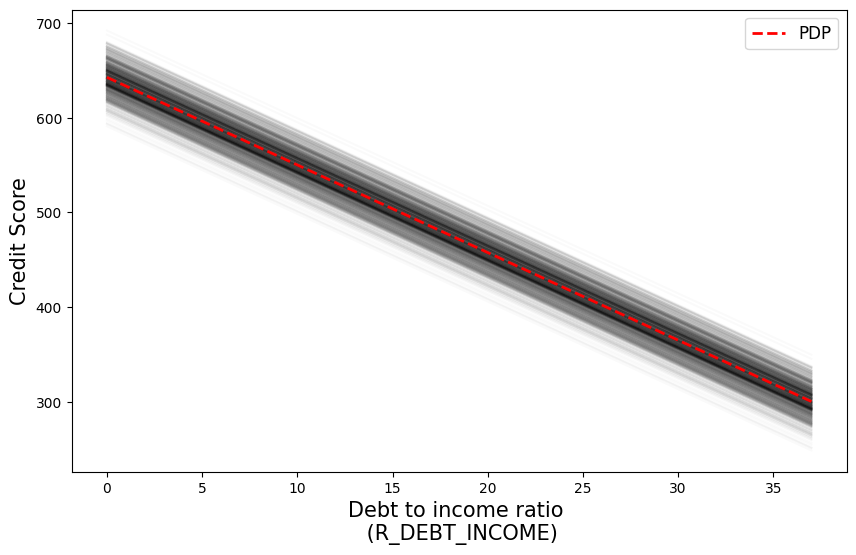

In [ ]:
#creating a list of values for the feature
feature_values = np.linspace(X['R_DEBT_INCOME'].min(), X['R_DEBT_INCOME'].max(), 100)
X_pdp = X.copy()

plt.figure(figsize=(10, 6))

all_preds = []
for i,row in X_pdp.iterrows():

    preds = []
    for value in feature_values:

        #replacing the value of the feature and to get a prediction
        row['R_DEBT_INCOME'] = value
        pred = model.predict(row.values)
        preds.append(pred)

    all_preds.append(preds)

    #plotting individual prediction line
    plt.plot(feature_values, preds, color='black',alpha=0.02)

#plotting average prediction line
average_preds = np.mean(all_preds,axis=0)
plt.plot(feature_values, average_preds, color='r',linewidth=2,label='PDP',linestyle='--')

plt.xlabel('Debt to income ratio \n (R_DEBT_INCOME)', size=15)
plt.ylabel('Credit Score', size=15)

plt.legend(fontsize=12)

fig.savefig("LM4_pdp_income.png", bbox_inches='tight')

Another visual representation of the negative relationship between the Credit Score and the debt-to-income ration (R_DEBT_INCOME).

##PDP Summary
A powerful visualization tool used to show the relationship between a feature and the predicted outcome while holding all other features constant. It isolates the effect of a single feature, allowing us to better understand its true influence on the target variable. A Partial Dependence Plot (PDP) represents the average predicted response as a feature varies, while all other features remain fixed at their average values. This helps reveal whether the relationship between the target variable and the feature is linear, monotonic, or more complex. PDPs provide a clearer view of the feature’s marginal effect without interference from other features. This is especially useful when features interact with each other. They are effective in visualizing complex models, such as decision trees or neural networks, where the influence of features is not straightforward. The x-axis represents the range of values for the selected feature. The y-axis represents the average predicted value of the target variable. A rising line suggests a positive relationship (as the feature increases, so does the target), while a falling line indicates a negative relationship. PDPs can also highlight whether a feature has a non-linear or threshold effect. For example, if the PDP for INCOME shows a sharp increase up to a certain point and then flattens, it might indicate that higher income improves credit scores up to a certain threshold, beyond which it has little impact. A steep slope in a PDP suggests that small changes in the feature value can lead to significant changes in the prediction. Plateaus or flat regions indicate that the feature has little to no effect on the target variable in those regions. PDPs allow us to visualize the true impact of a feature, independent of other variables. They are particularly valuable for complex models where features may interact with each other, making it hard to disentangle their effects.

#**SHAP: (SHapley Additive exPlanations)**



In [ ]:
#calculating SHAP values
explainer = shap.KernelExplainer(model.predict,X)
shap_values = explainer(X)
shap.plots.waterfall(shap_values[0], show=False)

preds = model.predict(X)

#calculating the average prediction
print(np.mean(preds))

  0%|          | 0/1000 [00:00<?, ?it/s]

586.7119999999825


The SHAP value is 586.7119999999825 suggesting that the feature(s) involved have a strong influence on the model's output.

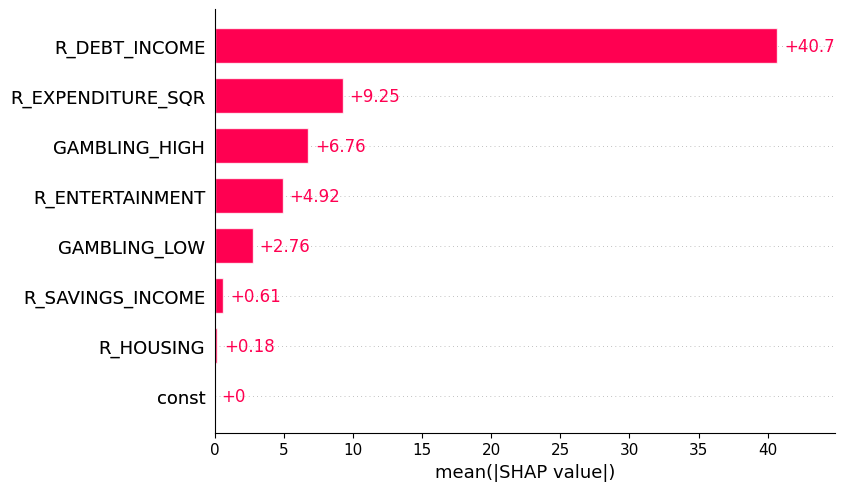

In [ ]:
#SHAP bar plot
plt.figure(facecolor='white')
shap.plots.bar(shap_values, show=False)

plt.show()

##SHAP
SHAP (SHapley Additive exPlanations) values are a state-of-the-art method for explaining the output of any machine learning model. Rooted in cooperative game theory, SHAP values assign each feature an importance score, reflecting its contribution to the prediction. SHAP provides both global and local interpretability, making it one of the most comprehensive methods for understanding model behavior. SHAP values quantify how much each feature contributes to a specific prediction by considering all possible feature combinations. They offer a unified measure of feature importance and provide insights into whether a feature increases or decreases a prediction. SHAP values are model-agnostic, meaning they can be applied to any machine learning model, from linear regression to complex neural networks. They provide both local explanations (for individual predictions) and global explanations (for the entire model). A SHAP summary plot visualizes the impact of each feature across all predictions. The x-axis represents the SHAP value (impact on the model output), while the y-axis lists the features. A positive SHAP value indicates that the feature increases the prediction, while a negative SHAP value suggests that the feature decreases the prediction. The magnitude of the SHAP value represents the strength of the feature’s contribution. This plot shows how the SHAP value of a feature changes as the feature itself varies. It is useful for understanding how a feature influences the prediction across its range and whether its effect is linear or interacts with other features. SHAP values for each feature can be visualized in a waterfall plot or a force plot, showing how the model arrives at a particular prediction.


According to the SHAP visual, we can see that R_DEBT_INCOME has the most significant impact on the model at +40.7, while R_HOUSING has the least significant impact on the model at +0.18.

#**RFE (Recursive Feature Elimination): A Systematic Approach to Feature Selection**

In [ ]:
#feature engineering
credit_score['GAMBLING_LOW'] = credit_score['CAT_GAMBLING'].apply(lambda x: 1 if x == 'Low' else 0)
credit_score['GAMBLING_HIGH']  = credit_score['CAT_GAMBLING'].apply(lambda x: 1 if x == 'High' else 0)
credit_score.drop(columns=['CAT_GAMBLING'], inplace=True)

#step 1: defining the features and target variable
X = credit_score.drop(columns=['CUST_ID', 'CREDIT_SCORE'])  # All columns except the target variable
y = credit_score['CREDIT_SCORE']               # Target variable

#step 2: importing RFE and LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

#step 3: initializing the linear regression model
model = LinearRegression()

#step 4: initializing RFE with the model and select the number of features to retain
rfe = RFE(estimator=model, n_features_to_select=5)

#step 5: fitting RFE to the data
rfe.fit(X, y)

#step 7: ranking the features
rfe_ranking = pd.DataFrame({
    'Feature': X.columns,
    'Ranking': rfe.ranking_,
    'Selected': rfe.support_

})

# Display the RFE results
rfe_ranking.sort_values(by='Ranking')

,Feature,Ranking,Selected
28,R_FINES_SAVINGS,1,True
29,R_FINES_DEBT,1,True
50,R_HOUSING,1,True
59,R_TAX_DEBT,1,True
68,R_UTILITIES,1,True
...,...,...,...
54,T_TAX_12,79,False
3,R_SAVINGS_INCOME,80,False
0,INCOME,81,False
2,DEBT,82,False


Here we can see that R_FINES_SAVINGS, R_FINES_DEBT, R_HOUSING, R_TAX_DEBT, and R_UTILITIES are the top ranked features.

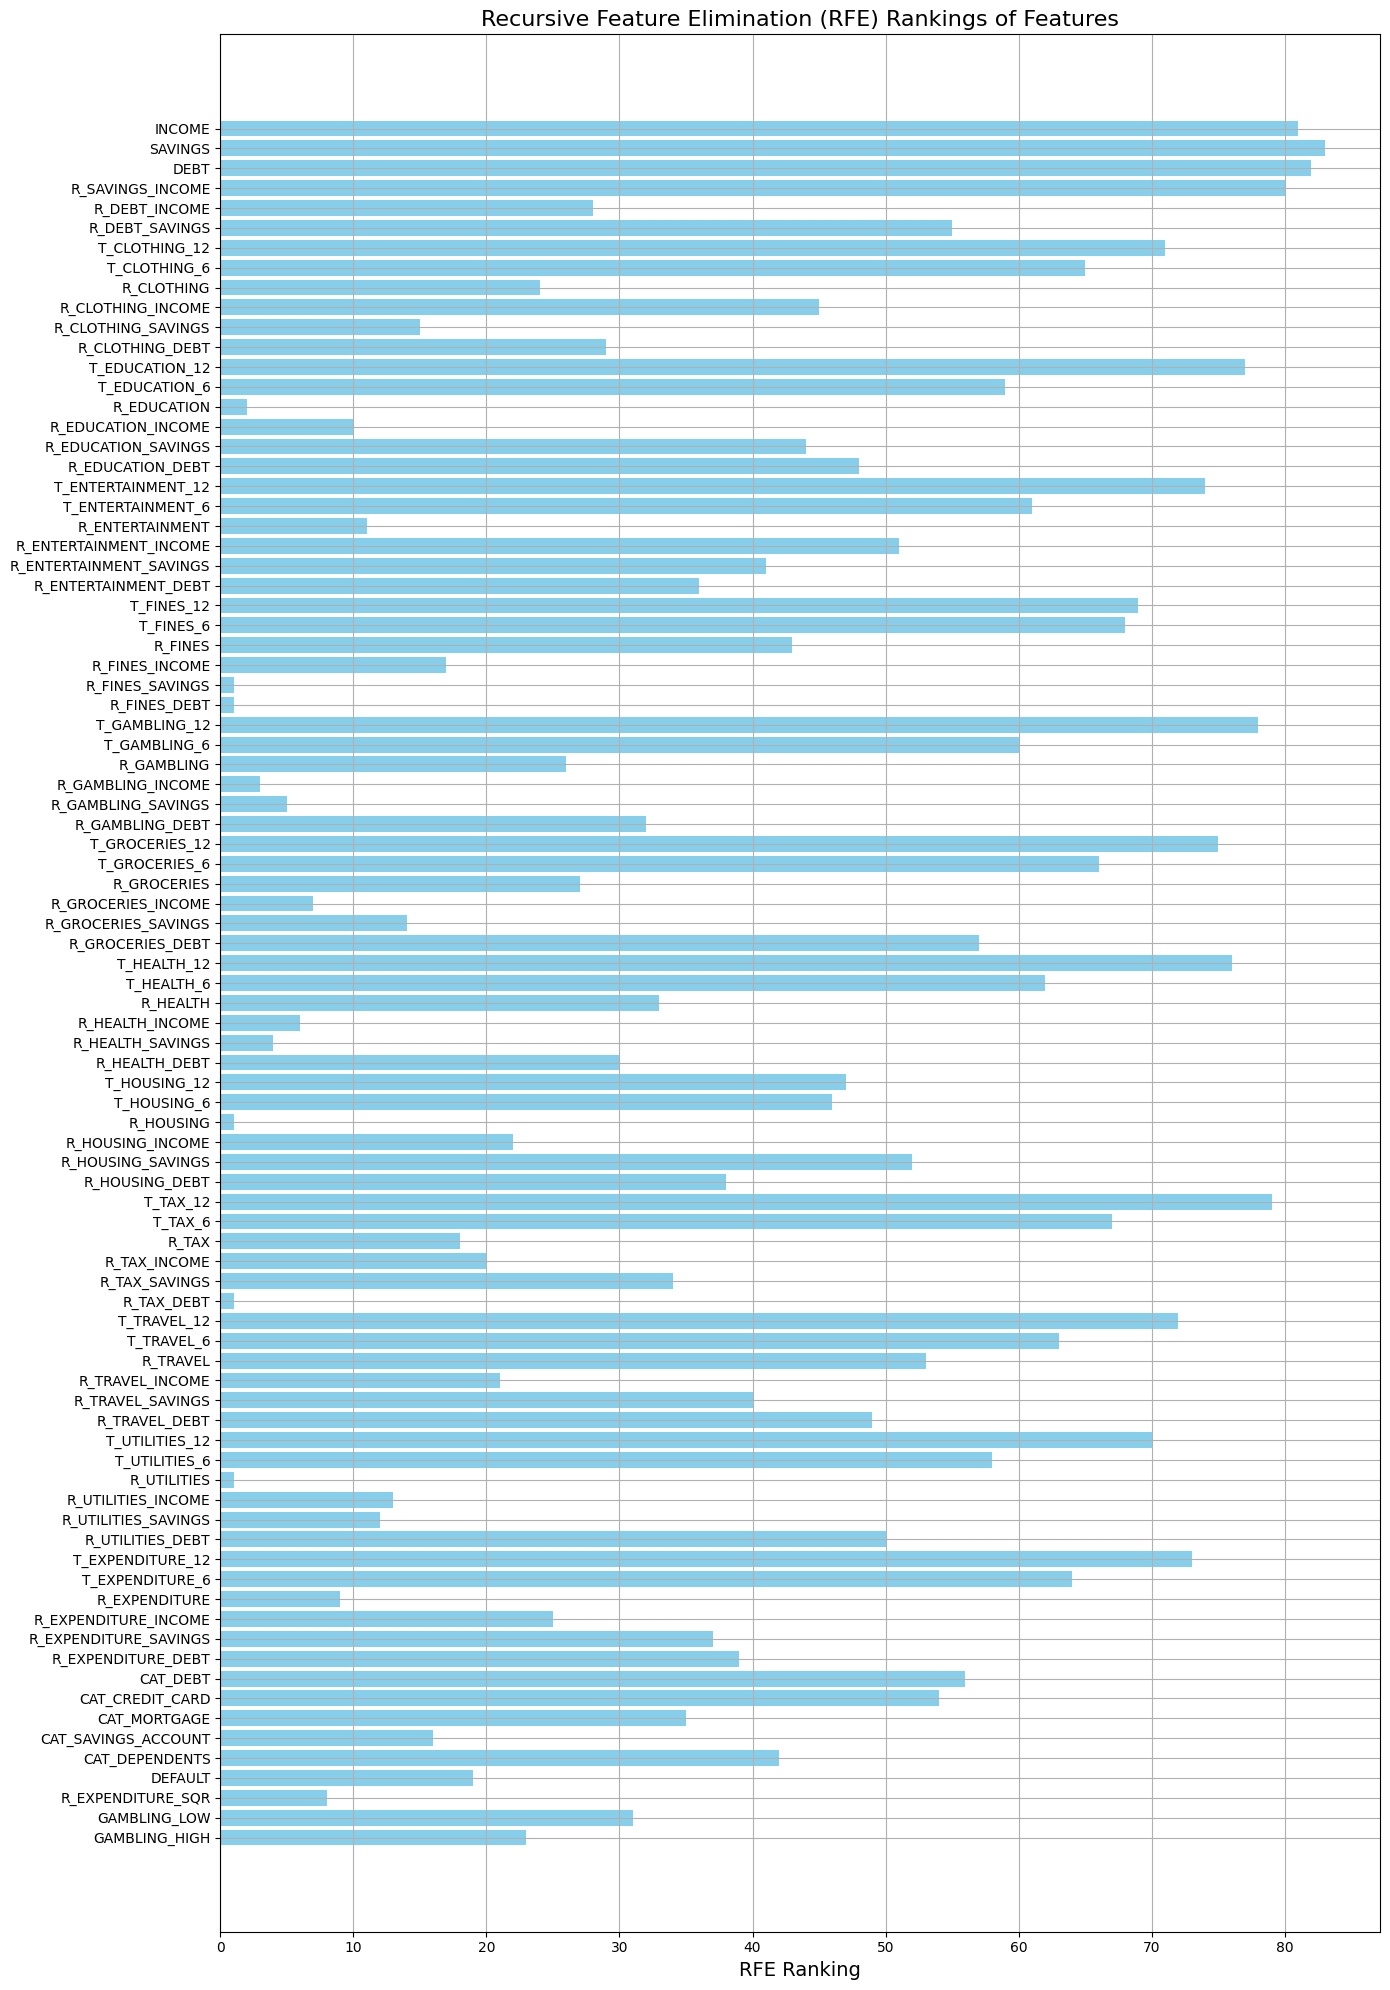

In [ ]:
#visualizing the feature rankings
plt.figure(figsize=(14, 20))

#creating the bar plot
plt.barh(rfe_ranking['Feature'], rfe_ranking['Ranking'], color='skyblue')

#adjusting labels and title
plt.xlabel('RFE Ranking', fontsize=14)
plt.title('Recursive Feature Elimination (RFE) Rankings of Features', fontsize=16)
plt.gca().invert_yaxis()  #inverting y-axis for better readability
plt.grid(True)

#adjusting font size for y-axis labels
plt.yticks(fontsize=10)

#adjusting the spacing between bars
plt.tight_layout()

plt.show()

In [ ]:
#step 8: creating a new dataset with only the selected features
X_selected = X.loc[:, rfe.support_]

#step 9: fitting a linear regression model using only the selected features
selected_model = LinearRegression()
selected_model.fit(X_selected, y)

#step 10: evaluating the new model's performance
from sklearn.metrics import mean_squared_error, r2_score

#predict using the new model
y_pred = selected_model.predict(X_selected)

#calculating performance metrics
mse = mean_squared_error(y, y_pred)
r2 = r2_score(y, y_pred)

#output
print(f"Mean Squared Error: {mse}")
print(f"R-Squared: {r2}")

Mean Squared Error: 3661.9053292551803
R-Squared: 0.08846583781559014


In [ ]:
X_selected.head()

,R_FINES_SAVINGS,R_FINES_DEBT,R_HOUSING,R_TAX_DEBT,R_UTILITIES
0,0.0026,0.0000,0.5060,0.0000,0.5038
1,0.0000,0.0000,0.5061,0.0063,0.5002
2,0.0017,0.0001,0.5056,0.0000,0.5041
3,0.0000,0.0000,0.5061,0.0027,0.5034
4,0.0000,0.0000,0.5061,0.0016,0.5020


##RFE Summary
Feature selection is one of the most crucial steps in building effective machine learning models. Not all features contribute equally to the prediction, and some can even introduce noise, leading to poor performance. Recursive Feature Elimination (RFE) is a powerful technique that systematically selects the most important features by recursively fitting a model and eliminating the least significant features. RFE is a backward feature selection method that uses a model to rank features based on their importance and recursively removes the least important ones. It starts with all the features and removes the weakest feature(s) until a desired number of features is reached. The goal is to find the best subset of features that improve model performance and reduce overfitting. Improves Model Performance: By removing irrelevant or redundant features, RFE helps reduce model complexity and prevent overfitting. Enhances Interpretability: With fewer features, the model becomes easier to interpret and understand. Reduces Computational Cost: With a smaller feature set, training time and computational resources are minimized.

Our Mean Squared Error (3661.9053292551803) and R-Squared (0.08846583781559014) are not the best. We would have to either add or change features in order to get better results.

#**LIME**


In [ ]:
#step 1: importing necessary libraries for building a model
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor

#step 2: splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#step 3: fitting a Decision Tree Regressor model
model = DecisionTreeRegressor(random_state=42)
model.fit(X_train, y_train)

DecisionTreeRegressor(random_state=42)

In [ ]:
#step 4: predicting on the test set and evaluate the model
y_pred = model.predict(X_test)

#calculating the mean squared error
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 1713.21


The MSE for this model is a little high (1713.21)

In [ ]:
#installing LIME
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=16dc02990ac4c4bd2d830d741cf2326f09814ff39b440cc1237bea033fb30c10
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [ ]:
#step 5: importing LIME and create an explainer object
import lime
import lime.lime_tabular

#creating a LIME explainer object using the training data
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values,
                                                   feature_names=X.columns,
                                                   class_names=['Credit_Score'],
                                                   mode='regression')

#step 6: selecting a single instance from the test set for explanation
instance = X_test.iloc[0].values  #selecting the first row for demonstration

#step 7: generating a LIME explanation for the selected instance
explanation = explainer.explain_instance(instance, model.predict)

#step 8: displaying the LIME explanation as a plot
explanation.show_in_notebook(show_table=True, show_all=False)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


In this instance, we can see that the models predicted credit score is 620 on a scale from 300-800. We can see that the model has predicted that a value of 44.05 for R_DEBT_INCOME, -7.10 for R_EXPENDITURE, etc. The actual values for this person for R_DEBT_INCOME are 1.5 and for R_EXPENDITURE are 0.56, etc. This is an indication that the model could be better tuned.

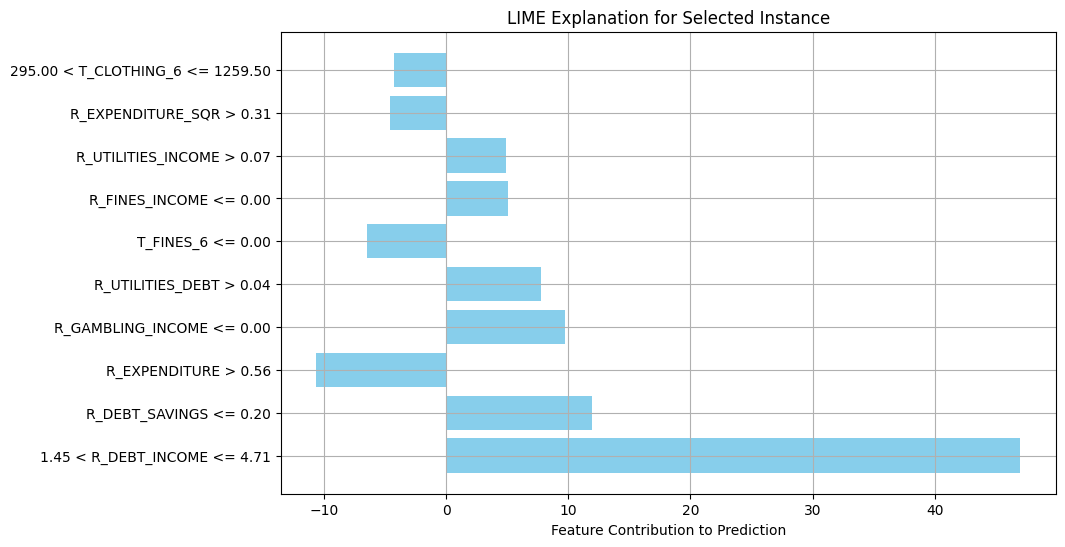

In [ ]:
#step 9: visualizing the explanation in a plot
import matplotlib.pyplot as plt

#extracting feature names and their contributions from the LIME explanation
features = [f for f, _ in explanation.as_list()]
contributions = [c for _, c in explanation.as_list()]

#creating a horizontal bar plot for LIME explanations
plt.figure(figsize=(10, 6))
plt.barh(features, contributions, color='skyblue')
plt.xlabel("Feature Contribution to Prediction")
plt.title("LIME Explanation for Selected Instance")
plt.grid(True)
plt.show()

##LIME Summary
As machine learning models become more complex, understanding how they arrive at their predictions becomes increasingly challenging. Local Interpretable Model-agnostic Explanations (LIME) is a powerful technique that explains the predictions of any machine learning model in an interpretable way. LIME is particularly useful for understanding individual predictions, making it a valuable tool for building trust in model outputs.  It explains individual predictions by creating an interpretable model (like a linear regression) locally around the prediction. This local model is used to approximate the behavior of the complex model for that specific instance, helping us understand why the model made a certain prediction. Interprets Any Model: LIME is model-agnostic, meaning it can be used to explain the predictions of any machine learning model, including black-box models like deep neural networks. Focuses on Local Behavior: Instead of explaining the entire model, LIME provides local explanations for individual predictions, making it ideal for understanding specific instances. Increases Trust: By explaining why a model made a specific prediction, LIME builds trust and helps identify biases or errors in the model.

Imagine you’re observing a large and complex machine (model) operating. If you want to understand why it made a specific move (prediction), you zoom in on that specific part (local instance) and study its behavior in detail. LIME allows you to zoom in on individual predictions and see which features are driving those predictions.